## Dataset Setup

In [1]:
import pathlib, os, sys, operator, re, datetime
from functools import reduce
import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import tensorflow_datasets as tfds
from tiny_imagenet import TinyImagenetDataset

# Enable or disable GPU
# To fully disable it, we need to hide all GPU devices from Tensorflow
# Make sure GPU is disabled for this inference part of the lab
ENABLE_GPU = True
# tf.debugging.set_log_device_placement(True)

if not ENABLE_GPU:
    tf.config.set_visible_devices([], 'GPU')

# Print Python and TF version, and where we are running
print(f'Running on Python Version: {sys.version}')
print(f'Using Tensorflow Version: {tf. __version__}')
if not tf.config.experimental.list_physical_devices("GPU"):
    print('Running on CPU')
else:
    print(f'Using GPU at: {tf.test.gpu_device_name()} (of {len(tf.config.experimental.list_physical_devices("GPU"))} available)')

Running on Python Version: 3.6.8 (default, May 31 2023, 10:28:59) 
[GCC 8.5.0 20210514 (Red Hat 8.5.0-18)]
Using Tensorflow Version: 2.6.2
Using GPU at: /device:GPU:0 (of 1 available)


In [2]:
# Original Source: https://github.com/ksachdeva/tiny-imagenet-tfds
# Class Version Source: https://github.com/Mluckydwyer/tiny-imagenet-tfds
# Setup our dataset
# ---------------------------------------------------------

tiny_imagenet_builder = TinyImagenetDataset()

# this call (download_and_prepare) will trigger the download of the dataset
# and preparation (conversion to tfrecords)
#
# This will be done only once and on next usage tfds will
# use the cached version on your host.
tiny_imagenet_builder.download_and_prepare(download_dir="~/tensorflow-datasets/downloads")

# class_names = tiny_imagenet_builder.info.features['label'].names
ds = tiny_imagenet_builder.as_dataset()
ds_train, ds_val = ds["train"], ds["validation"]
assert(isinstance(ds_train, tf.data.Dataset))
assert(isinstance(ds_val, tf.data.Dataset))

# Training Dataset
ds_train = ds_train.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
ds_val = ds_val.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Dataset metadata
ds_info = tiny_imagenet_builder.info

## Working with the Dataset

In [3]:
# We need to read the "human readable" labels so we can translate with the numeric values
# Read the labels file (words.txt)
with open(os.path.abspath('wnids.txt'), 'r') as f:
    wnids = [x.strip() for x in f]

# Map wnids to integer labels
wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
label_to_wnid = {v: k for k, v in wnid_to_label.items()}

# Use words.txt to get names for each class
with open(os.path.abspath('words.txt'), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.items():
        wnid_to_words[wnid] = [w.strip() for w in words.split(',')]

class_names = [str(wnid_to_words[wnid]) for wnid in wnids]

In [4]:
# Helper function to get the label name
def img_class(img_data, idx=None):
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']
    # Handle batches of images correctly
    if idx != None:
        image, label, id, label_name = img_data["image"][idx], img_data["label"][idx], img_data["id"][idx], img_data["metadata"]['label_name'][idx]
    
    return f"{label_name} (class index: {label} - id: {id})"


# Helper function to show basic info about an image
def img_info(img, idx=None, display=True, title_apend=""):
    image = img['image']

    # Print the clas
    class_str = img_class(img, idx)
    print(f"Label: {class_str}")
    
    # Display the image
    if display:
        plt.figure()
        plt.title(title_apend + class_str)
        # Handle batches correctly
        if image.shape.ndims > 3:
            plt.imshow(image.numpy().reshape(64, 64, 3))
        else:
            plt.imshow(image.numpy())

--- Train & Validation dataset info ---
Train: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>
Validation: <PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>

--- Show an example image ---
Label: b'swimming trunks, bathing trunks' (class index: 136 - id: b'n04371430')

 Show some other examples


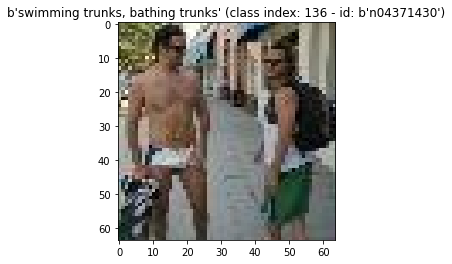

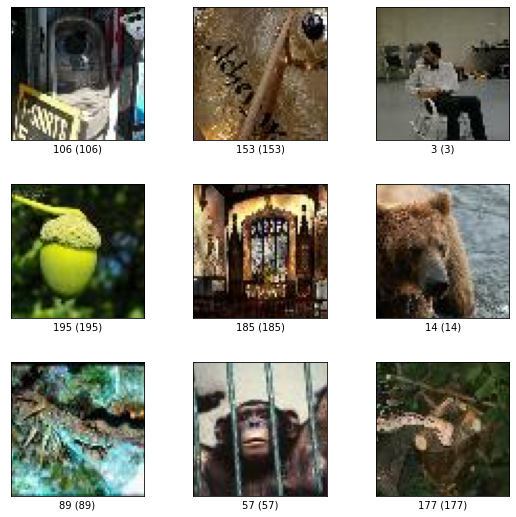

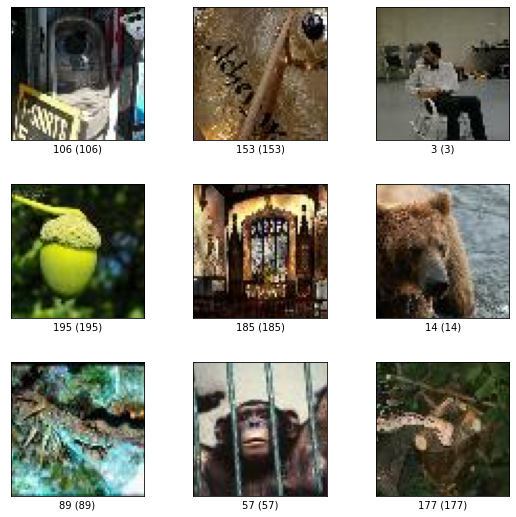

In [5]:
# Print the dataset types and info
print("--- Train & Validation dataset info ---")
print(f"Train: {ds_train}")
print(f"Validation: {ds_val}")
# print(f"Dataset Info: {ds_info}") # Uncomment to print Dataset info

print("\n--- Show an example image ---")
for example in ds_val.take(1):
    img_info(example)

print("\n Show some other examples")
tfds.show_examples(ds_val, ds_info, rows=3, cols=3)


--- Image 0 ---
Image Data Type: <dtype: 'uint8'>
Image Shape: (64, 64, 3)
Image Memory: 12288 bytes
Label: b'espresso' (class index: 8 - id: b'n07920052')

--- Image 1 ---
Image Data Type: <dtype: 'uint8'>
Image Shape: (64, 64, 3)
Image Memory: 12288 bytes
Label: b'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis' (class index: 158 - id: b'n02415577')

--- Image 2 ---
Image Data Type: <dtype: 'uint8'>
Image Shape: (64, 64, 3)
Image Memory: 12288 bytes
Label: b'plate' (class index: 143 - id: b'n07579787')


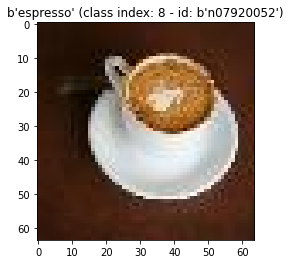

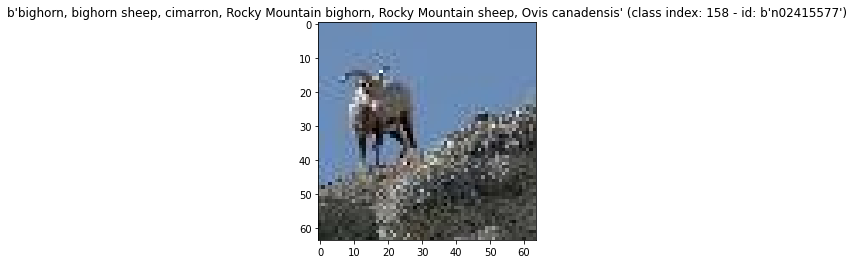

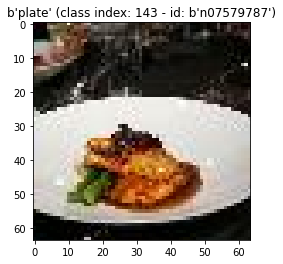

In [6]:
#     : Print and visualize three inputs from the validation set
#     : Print the storage data type
#     : Print and note the dimensions of each image
#     : Print the memory required to store each image

# Sample Images
sample_imgs = []
for index, img_data in enumerate(ds_val.take(3)):
    sample_imgs.append(img_data)
    image, label, id, label_name = img_data["image"], img_data["label"], img_data["id"], img_data["metadata"]['label_name']

    print(f'\n--- Image {index} ---')
    # Your Code Here
    print(f"Image Data Type: {image.dtype}")
    print(f"Image Shape: {image.shape}")
    print(f"Image Memory: {image.numpy().nbytes} bytes")
    img_info(img_data)

In [7]:
# Export each of the three inputs to a binary file which will be used to load the images into C++ later
# NOTE: First flatten the array (ex: 4D --> 1D). So 64*64*3 = 12288 element 1D array

# Make a directory for our image data
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

# Create a metadata file
metadata_file = open(os.path.join(img_dir, f'metadata.txt'), 'w')
metadata_file.write(f'Number\t\tDims\t\tClass Data\n')

# Export each image
for index, img_data in enumerate(sample_imgs):
    img_file = open(os.path.join(img_dir, f'image_{index}.bin'), 'wb')
    
    # Your Code Here
    # Flatten the image
    image = img_data["image"].numpy().flatten()
    # Write the image to the file
    img_file.write(image)
    img_file.close()

    # Write the image metadata for reference later
    class_str = img_class(img_data)
    metadata_file.write(f'{index}\t\t{img_data["image"].shape}\t\t{class_str}\n')
metadata_file.close()

## Model Setup

In [8]:
# Load the model
# Now we will load the H5 model! Please make sure the h5 model file is present in the below directory.
# You can download this from the Canvas Page and place it in the same directory as this notebook.

# model_path = os.path.abspath(""/home/dwyer/482/dev/CNN_TinyImageNet_2.h5)" # Uncomment this to use a non-relative path
model_path = os.path.abspath("CNN_TinyImageNet_2.h5")

# Your Code Here
model = tf.keras.models.load_model(model_path)

# Print a summary of the model
# NOTE: https://www.tensorflow.org/versions/r2.6/api_docs/python/tf/keras/Model
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        3

# Running Infrence

Label: [b'birdhouse'] (class index: [72] - id: [b'n02843684'])
Best Guess [class index]: ['comic book'] [173]
Best Guess Confidence (percent / 1.0): [1.]
Top 15 Guesses (class index): ['[ [173]', '[ [0]', '[ [1]', '[ [2]', '[ [3]', '[ [4]', '[ [5]', '[ [6]', '[ [7]', '[ [8]', '[ [9]', '[ [10]', '[ [11]', '[ [12]', '[ [13]']
Top 15 Guesses Confidence (percent / 1.0): [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


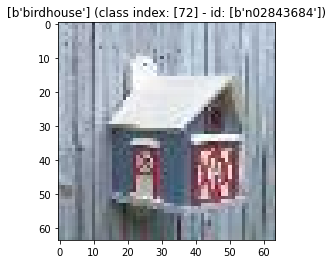

In [9]:
# Running infrence on our model
# We can run an infrence of our model by doing the following (we are doing batches of 1 here)
for example in ds_train.batch(1).take(1):
    img_info(example)
    
    # Make a prediction
    pred = model.predict(example["image"])
    # print(f'Raw 200 Class Weighted Prediction:\n{pred}') # Uncomment to see the raw prediction
    
    # What is out best guess?
    best_guess = tf.math.argmax(pred, axis=1).numpy() # Our output is 200 weighted value, we want the most likely
    print(f'Best Guess [class index]: {class_names[best_guess[0]]} [{best_guess[0]}]')
    print(f'Best Guess Confidence (percent / 1.0): {pred[0][best_guess]}')

    # What are our top 15 guesses?
    top_15 = tf.math.top_k(pred, k=15)
    print(f'Top 15 Guesses (class index): {[f"{class_names[idx][0]} [{idx}]" for idx in top_15.indices[0]]}')
    print(f'Top 15 Guesses Confidence (percent / 1.0): {top_15.values}')

Label: b'espresso' (class index: 8 - id: b'n07920052')
Best Guess [class index]: ['lampshade', 'lamp shade'] [61]
Best Guess Confidence (percent / 1.0): [1.]
Label: b'bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis' (class index: 158 - id: b'n02415577')
Best Guess [class index]: ['coral reef'] [34]
Best Guess Confidence (percent / 1.0): [1.]
Label: b'plate' (class index: 143 - id: b'n07579787')
Best Guess [class index]: ['comic book'] [173]
Best Guess Confidence (percent / 1.0): [1.]


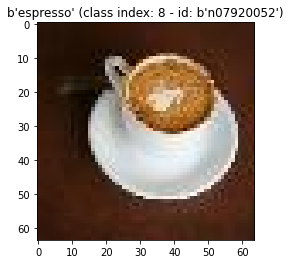

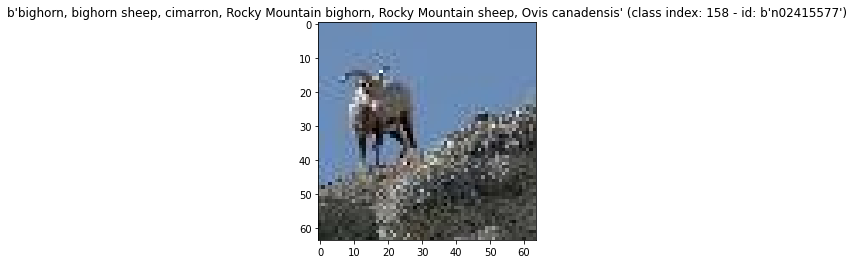

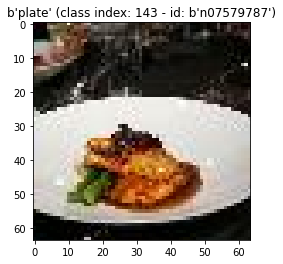

In [10]:
# Run infrence for our previous 3 sample images

for img_data in sample_imgs:
    img_info(img_data)
    
    # Make a prediction
    pred = model.predict(img_data["image"].numpy().reshape(1, 64, 64, 3))
    # print(f'Raw 200 Class Weighted Prediction:\n{pred}') # Uncomment to see the raw prediction
    
    # What is out best guess?
    best_guess = tf.math.argmax(pred, axis=1).numpy() # Our output is 200 weighted value, we want the most likely
    print(f'Best Guess [class index]: {class_names[best_guess[0]]} [{best_guess[0]}]')
    print(f'Best Guess Confidence (percent / 1.0): {pred[0][best_guess]}')


In [50]:
# TODO: Calculate the Top-1, Top-5, and Top-10 Accuracy of the validation dataset
total = acc_top1 = acc_top5 = acc_top10 = 0
print(ds_val)
print(ds_val.batch(32))

for batch in ds_val.batch(32):
    print(batch["image"].numpy().shape)
    print(batch["label"].numpy().shape)
    # Make a prediction
    pred = model.predict(batch["image"].numpy())
    top_10 = tf.math.top_k(pred, k=10)
    top_5 = tf.math.top_k(pred, k=5)
    top_1 = tf.math.top_k(pred, k=1)
    
    # np.isin() returns a boolean array where the value is True if the element of the first input is in the second input
    # np.sum() sums the boolean array, which is the same as counting the number of True values
    acc_top10 += np.sum(np.isin(batch["label"].numpy(), top_10.indices))
    acc_top5 += np.sum(np.isin(batch["label"].numpy(), top_5.indices))
    acc_top1 += np.sum(np.isin(batch["label"].numpy(), top_1.indices))
    
    total += len(batch["label"].numpy())

print(f'Top-1 Accuracy: {acc_top1 / total}')
print(f'Top-5 Accuracy: {acc_top5 / total}')
print(f'Top-10 Accuracy: {acc_top10 / total}')
print(f'Total Images: {total}')


<PrefetchDataset shapes: {id: (), image: (64, 64, 3), label: (), metadata: {label_name: ()}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>
<BatchDataset shapes: {id: (None,), image: (None, 64, 64, 3), label: (None,), metadata: {label_name: (None,)}}, types: {id: tf.string, image: tf.uint8, label: tf.int64, metadata: {label_name: tf.string}}>
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3)
(32,)
(32, 64, 64, 3

In [12]:
# Print all of the possible classes of the dataset and report how many there are in each split (train + validation)

# count all the unique classes in a dataset
def count_class(ds):
    class_count = {}
    num_unique = 0
    for img_data in ds:
        label = img_data["label"].numpy()
        if label in class_count:
            class_count[label] += 1
        else:
            class_count[label] = 1
            num_unique += 1
    return class_count, num_unique

# sum the class counts for each split
class_counts_train, count_unique_train = count_class(ds_train)
class_counts_val, count_unique_val = count_class(ds_val)

# Print all the classes present in the entire dataset
print(f'Entire dataset class names: {class_names}')
print(f'Entire dataset class IDs: {ds_info.features["label"].names}')
print(f'Number of classes in entire dataset: {len(ds_info.features["label"].names)}')

# Print the number of classes in each split
print(f'Number of unique Classes in Train: {count_unique_train}')
print(f'Number of unique Classes in Validation: {count_unique_val}')

# print the total number of images in the dataset
# print(f'Total number of images in dataset: {ds_info.splits["train"].num_examples + ds_info.splits["validation"].num_examples}')
print(f'Total number of images in dataset: {len(ds_train) + len(ds_val)}')


Entire dataset class names: ["['Egyptian cat']", "['reel']", "['volleyball']", "['rocking chair', 'rocker']", "['lemon']", "['bullfrog', 'Rana catesbeiana']", "['basketball']", "['cliff', 'drop', 'drop-off']", "['espresso']", '[\'plunger\', "plumber\'s helper"]', "['parking meter']", "['German shepherd', 'German shepherd dog', 'German police dog', 'alsatian']", "['dining table', 'board']", "['monarch', 'monarch butterfly', 'milkweed butterfly', 'Danaus plexippus']", "['brown bear', 'bruin', 'Ursus arctos']", "['school bus']", "['pizza', 'pizza pie']", "['guinea pig', 'Cavia cobaya']", "['umbrella']", "['organ', 'pipe organ']", "['oboe', 'hautboy', 'hautbois']", "['maypole']", "['goldfish', 'Carassius auratus']", "['potpie']", "['hourglass']", "['seashore', 'coast', 'seacoast', 'sea-coast']", "['computer keyboard', 'keypad']", "['Arabian camel', 'dromedary', 'Camelus dromedarius']", "['ice cream', 'icecream']", "['nail']", "['space heater']", "['cardigan']", "['baboon']", "['snail']", "

## Model Exploration

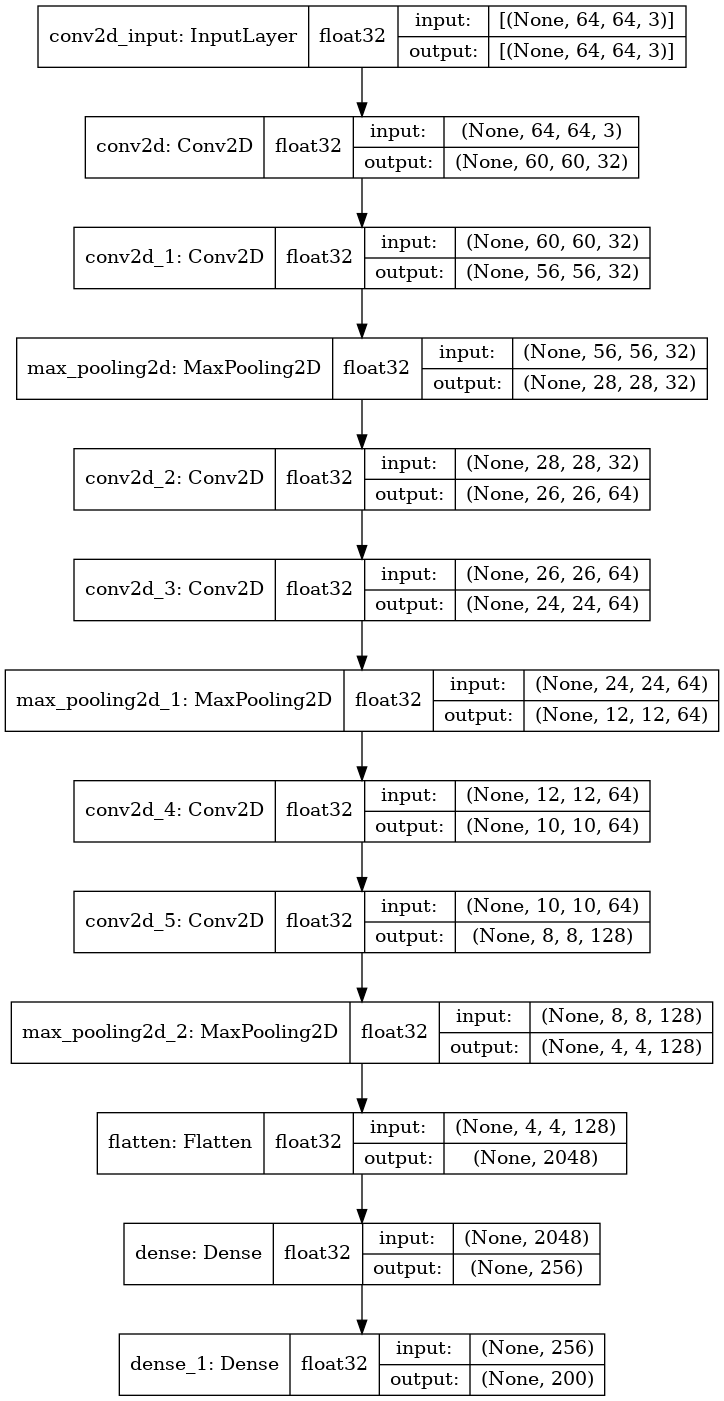

In [13]:
# Visualize the model in Netron and include an image here.
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=True, expand_nested=True) # Uncomment this to generate an image visualization


conv1_weights data type: float32
conv1_weights shape: (5, 5, 32, 32)
conv1_weights number of bytes: 102400
conv2_weights data type: float32
conv2_weights shape: (3, 3, 64, 128)
conv2_weights number of bytes: 294912
5 5


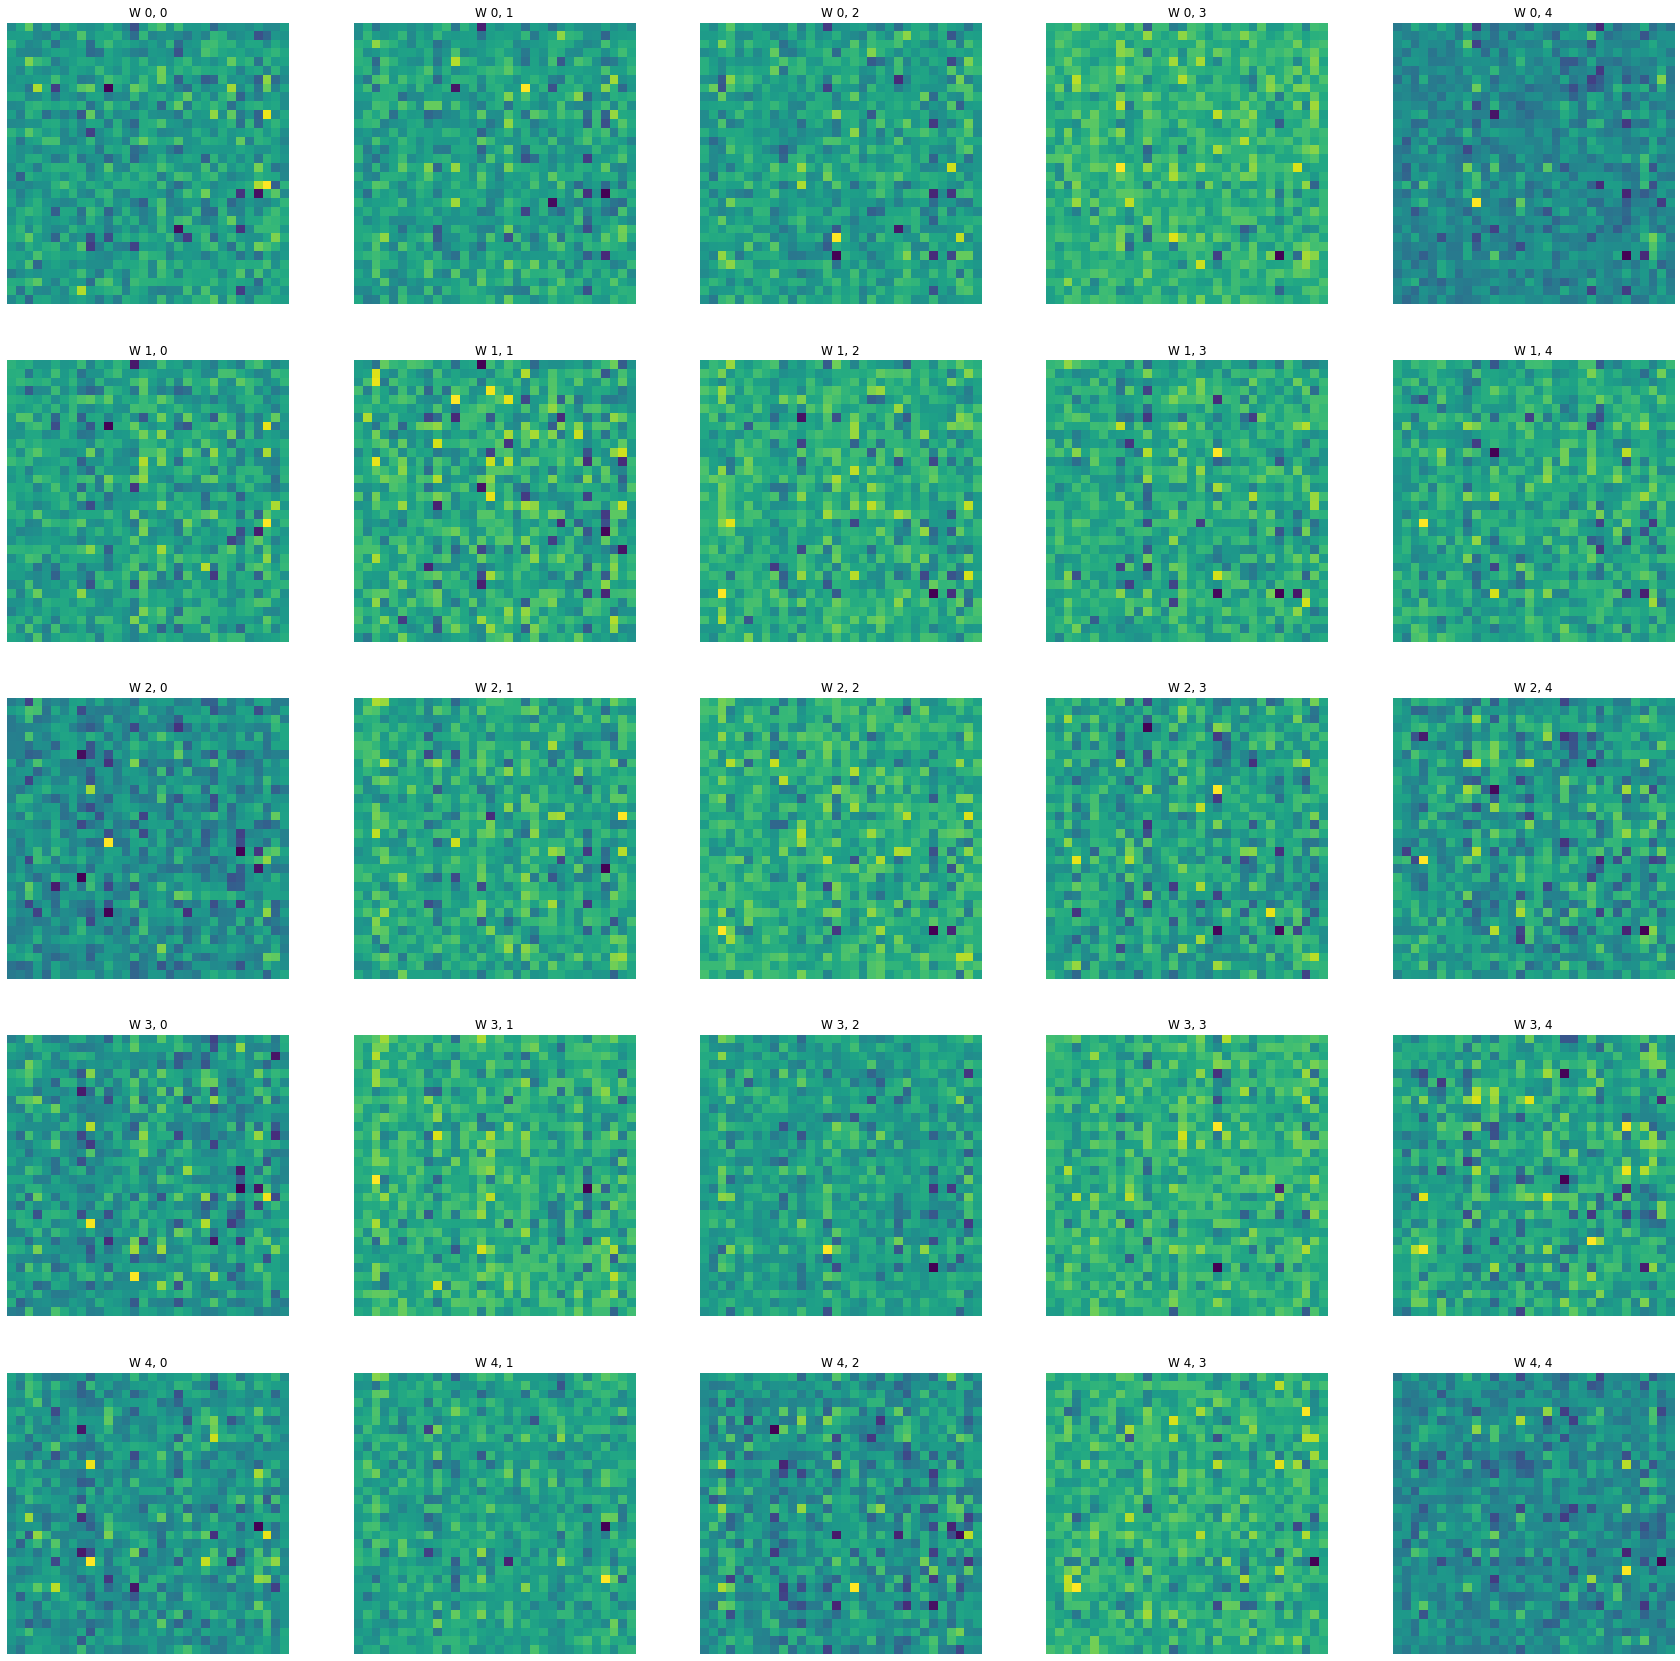

3 3


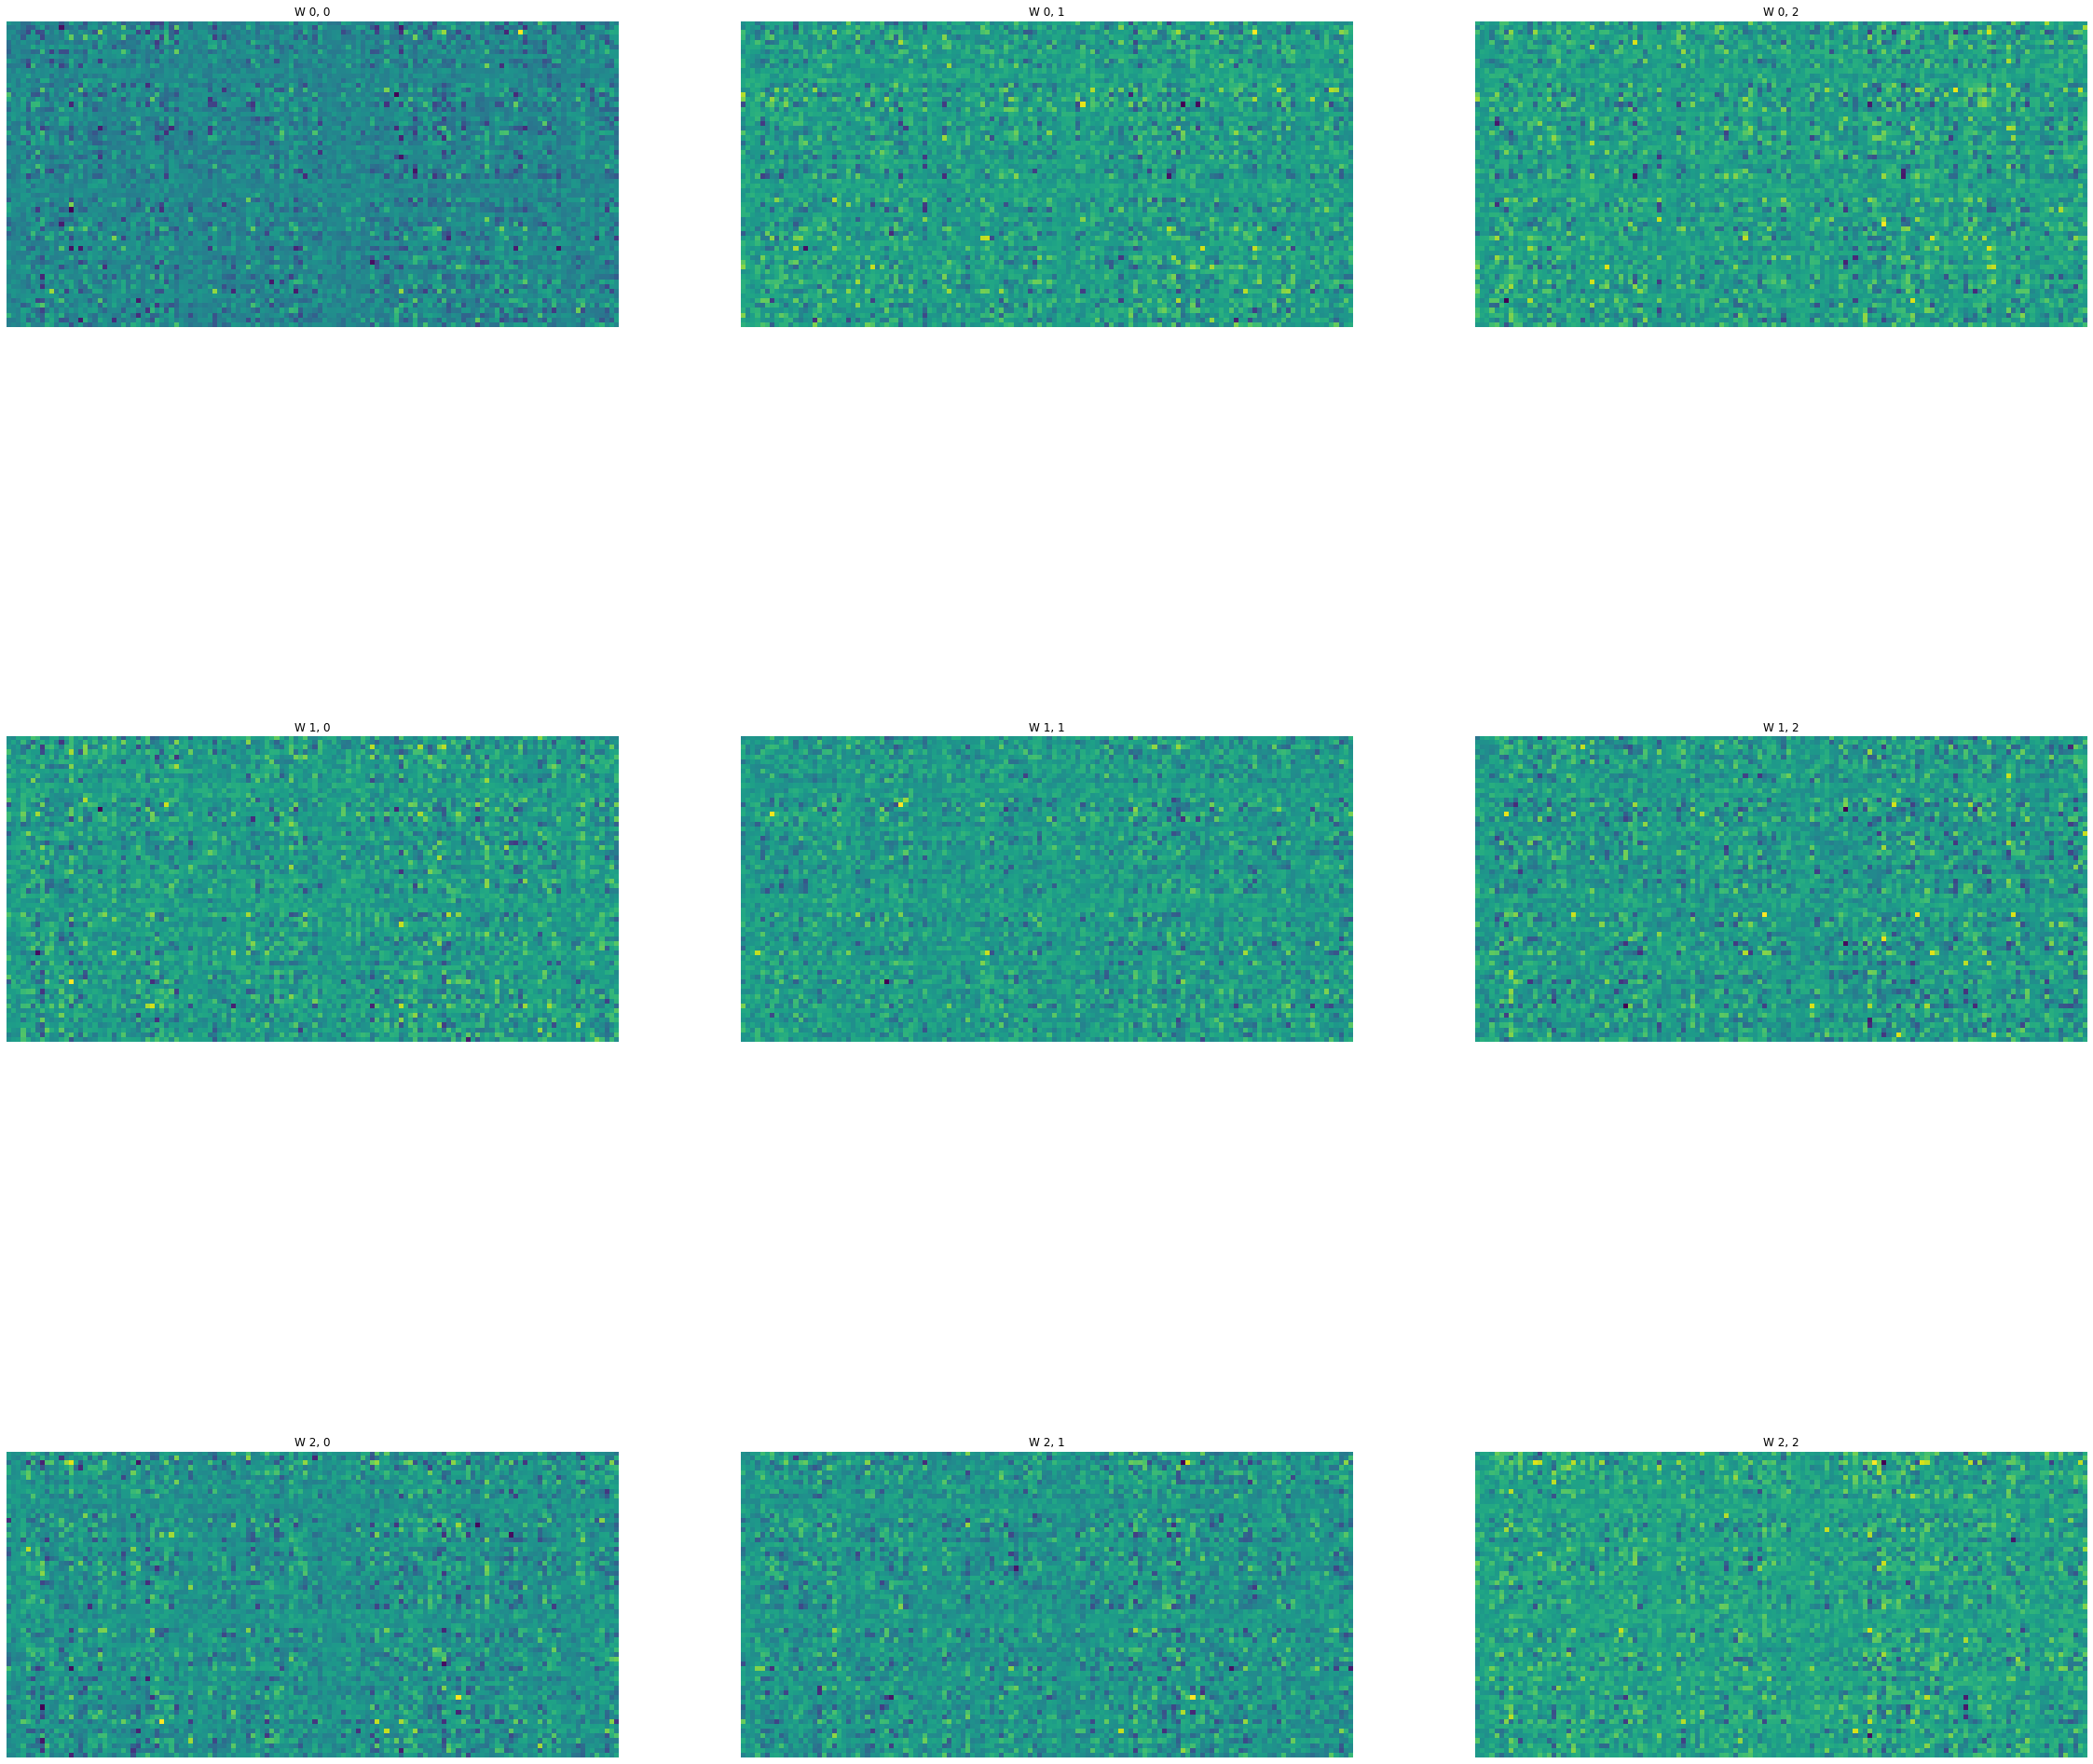

In [14]:
# We can view the layer weights as well. Here we are pretending they are images
# Visualize the 2 convolutional layers filter sets (weights) (one at the beginning and one at the end)

# Get the weights of the first convolutional layer
conv1_weights = model.layers[1].get_weights()[0]
# provide the data type, dimensions, and memory needed to store the weights on this layer
print(f'conv1_weights data type: {conv1_weights.dtype}')
print(f'conv1_weights shape: {conv1_weights.shape}')
print(f'conv1_weights number of bytes: {conv1_weights.nbytes}')

# Get the weights of the last convolutional layer
conv2_weights = model.layers[-5].get_weights()[0]
print(f'conv2_weights data type: {conv2_weights.dtype}')
print(f'conv2_weights shape: {conv2_weights.shape}')
print(f'conv2_weights number of bytes: {conv2_weights.nbytes}')

# Plot the weights of the first convolutional layer 
n_rows = conv1_weights.shape[0]
n_cols = conv1_weights.shape[1]
print(n_rows, n_cols)

# plot the weights on the same figure
plt.figure(figsize=(n_rows, n_cols))
plt.title("First Convolutional Layer Weights")
for i in range(n_rows):
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
        plt.title(f"W {i}, {j}")
        plt.imshow(conv1_weights[i, j, :, :], cmap='viridis')
        plt.axis('off')
        # increase the size of the subplots
        plt.gcf().set_size_inches(30, 30)
plt.show()


# Plot the weights of the last convolutional layer 
n_rows = conv2_weights.shape[0]
n_cols = conv2_weights.shape[1]
print(n_rows, n_cols)

# plot the weights on the same figure with 16 images per row
plt.figure(figsize=(n_rows, n_cols))
plt.title("First Convolutional Layer Weights")
for i in range(n_rows):
    for j in range(n_cols):
        plt.subplot(n_rows, n_cols, i * n_cols + j + 1)
        plt.title(f"W {i}, {j}")
        plt.imshow(conv2_weights[i, j, :, :], cmap='viridis')
        plt.axis('off')
        # increase the size of the subplots
        plt.gcf().set_size_inches(40, 40)
plt.show()


conv2d data type: float32
conv2d shape: (1, 60, 60, 32)
conv2d number of bytes: 460800
conv2d_1 data type: float32
conv2d_1 shape: (1, 56, 56, 32)
conv2d_1 number of bytes: 401408
max_pooling2d data type: float32
max_pooling2d shape: (1, 28, 28, 32)
max_pooling2d number of bytes: 100352
conv2d_2 data type: float32
conv2d_2 shape: (1, 26, 26, 64)
conv2d_2 number of bytes: 173056
conv2d_3 data type: float32
conv2d_3 shape: (1, 24, 24, 64)
conv2d_3 number of bytes: 147456
max_pooling2d_1 data type: float32
max_pooling2d_1 shape: (1, 12, 12, 64)
max_pooling2d_1 number of bytes: 36864
conv2d_4 data type: float32
conv2d_4 shape: (1, 10, 10, 64)
conv2d_4 number of bytes: 25600
conv2d_5 data type: float32
conv2d_5 shape: (1, 8, 8, 128)
conv2d_5 number of bytes: 32768
max_pooling2d_2 data type: float32
max_pooling2d_2 shape: (1, 4, 4, 128)
max_pooling2d_2 number of bytes: 8192


/home/sszabo/github/CPRE587/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


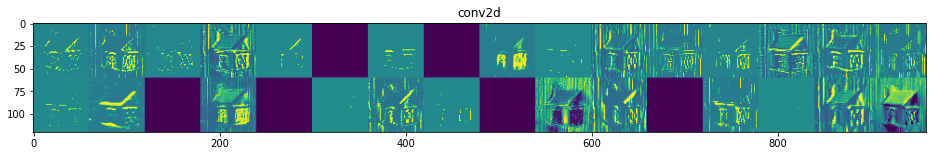

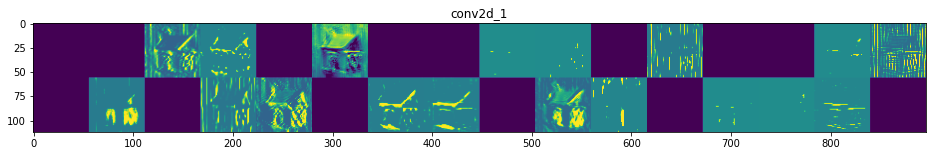

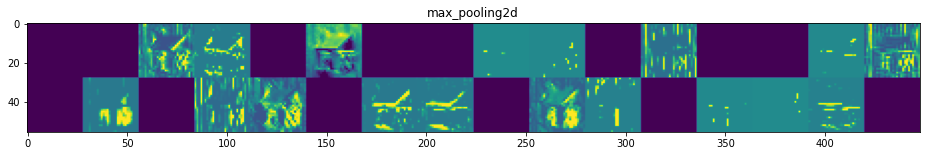

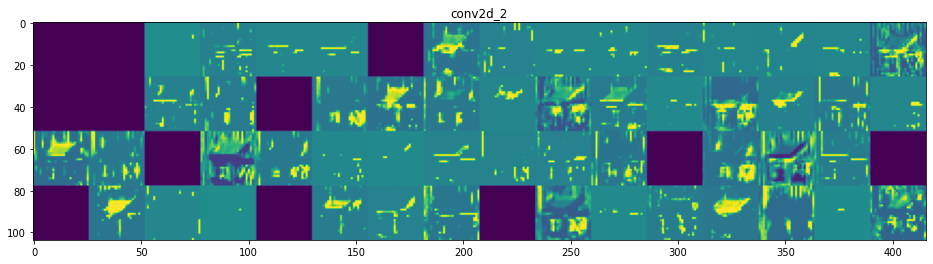

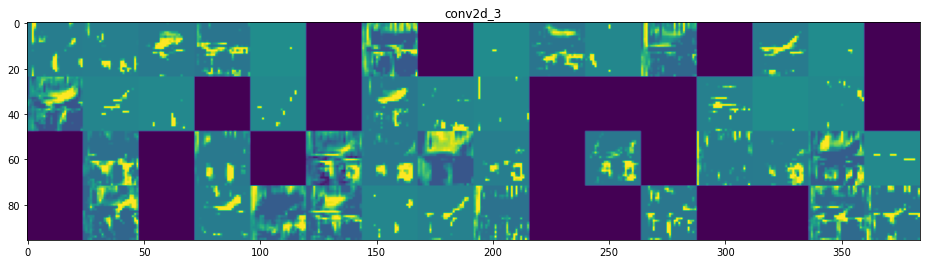

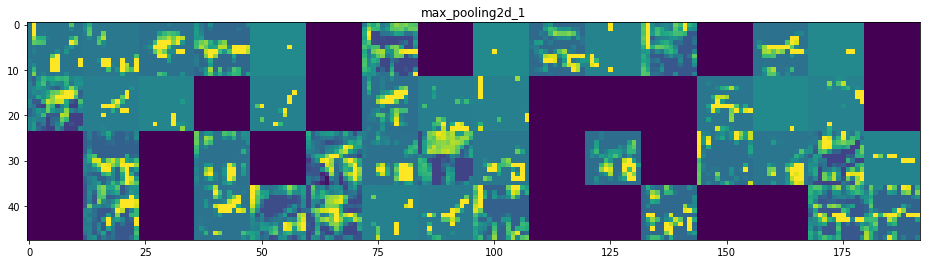

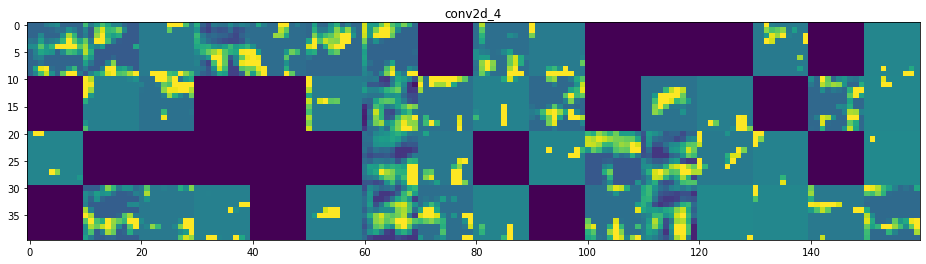

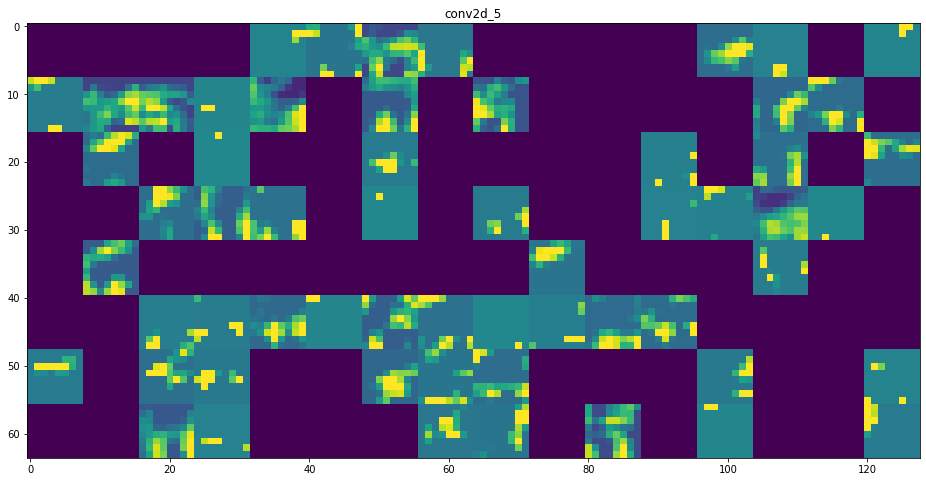

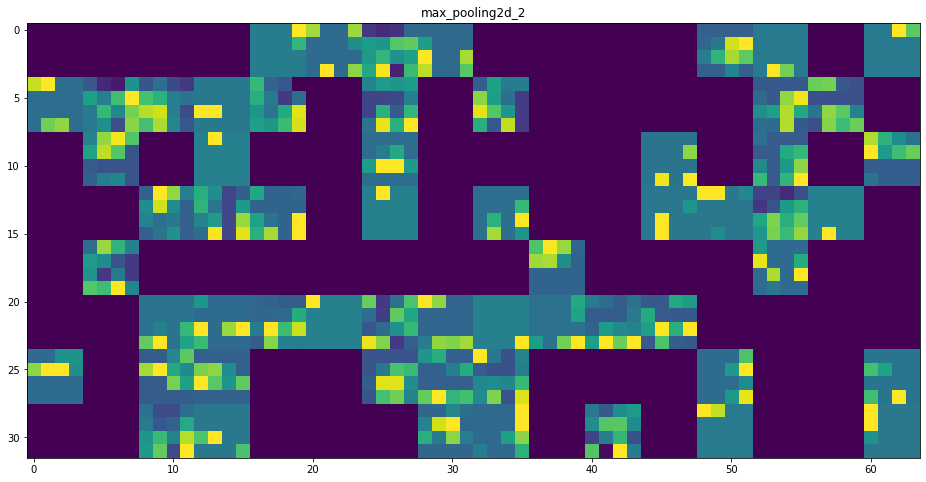

In [15]:
# We can again view the layer outputs as well. Here we are pretending they are images
# Using an inference of any test images, visualize the intermediate feature maps for 2 of the intermediate channels
# Visualize the 2 convolutional layers outputs (intermediate feature maps) (one at the beginning and one at the end)

# visualize 1st 10 layers and not last one as it has too few dimensions
layer_outputs = [layer.output for layer in model.layers[:9]]
activations_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activations_model.predict(example["image"])

layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

images_per_row = 16

# plot the activations of the first 2 layers
for layer_name, layer_activation in zip(layer_names, activations):
    print(f'{layer_name} data type: {layer_activation.dtype}')
    print(f'{layer_name} shape: {layer_activation.shape}')
    print(f'{layer_name} number of bytes: {layer_activation.nbytes}')
    # number of features in the feature map
    n_features = layer_activation.shape[-1]
    # the feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]
    # tiles the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):  # tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :, col * images_per_row + row]
            # post-processes the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col + 1) * size,  # displays the grid
                         row * size: (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


# Get the outputs of the first convolutional layer
# conv1_outputs = model.layers[0].output[0]
# # provide the data type, dimensions, and memory needed to store the outputs on this layer
# print(conv1_outputs.dtype)
# print(conv1_outputs.shape)

# # Get the outputs of the last convolutional layer
# conv2_outputs = model.layers[-4].output[0]
# print(conv2_outputs.dtype)
# print(conv2_outputs.shape)

# # Plot the outputs of the first convolutional layer
# plt.figure()
# plt.title("First Convolutional Layer Outputs")
# plt.imshow(conv1_outputs[:, :, 4], cmap='viridis')

# # Plot the outputs of the last convolutional layer
# plt.figure()
# plt.title("Last Convolutional Layer Outputs")
# plt.imshow(conv2_outputs, cmap='viridis')

In [16]:
# Export the filters/weights se we can use them later
# Make a directory for our image data
model_dir = os.path.abspath('model_data')
pathlib.Path(model_dir).mkdir(exist_ok=True)


# Export each image
conv_index = dense_index = 1 # layer index starts from one
for layer_idx, layer in enumerate(model.layers):
    if re.match("conv", layer.name):
        weight_file_name = os.path.join(model_dir, f'conv{conv_index}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'conv{conv_index}_bias.bin')
        conv_index += 1
    elif re.match("dense", layer.name):
        weight_file_name = os.path.join(model_dir, f'dense{dense_index}_weights.bin')
        bias_file_name = os.path.join(model_dir, f'dense{dense_index}_bias.bin')
        dense_index += 1
    else:
        continue
    # Flatten the image
    weights = layer.get_weights()[0].flatten()
    biases = layer.get_weights()[1].flatten()
    # Write the image to the file
    weight_file = open(weight_file_name, 'wb')
    weight_file.write(weights)
    weight_file.close()
    
    bias_file = open(bias_file_name, 'wb')
    bias_file.write(biases)
    bias_file.close()

print(f"All the convolution and dense (fully connected) weights and biases successfully exported to input folders in {model_dir} directory")

All the convolution and dense (fully connected) weights and biases successfully exported to input folders in /home/sszabo/github/CPRE587/lab1/model_data directory


In [17]:
# Export the intermediate layer outputs for each of the input for all of the layers
img_dir = os.path.abspath('img_data')
pathlib.Path(img_dir).mkdir(exist_ok=True)

for img_idx, img in enumerate(sample_imgs):
    file_dir = os.path.join(img_dir, f'test_input_{img_idx}')
    pathlib.Path(file_dir).mkdir(exist_ok=True)
    
    for layer_idx, layer in enumerate(model.layers):
        aux_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output])
        
        # Store the intermediate output
        output = aux_model.predict(img["image"].numpy().reshape(1, 64, 64, 3))
        output_file_name = os.path.join(file_dir, f'layer_{layer_idx}_output.bin')
        output_file = open(output_file_name, 'wb')
        output_file.write(output)
        output_file.close()

print(f"All the corresponding intermediate layer outputs successfully exported to each input folder in the {img_dir} directory")

All the corresponding intermediate layer outputs successfully exported to each input folder in the /home/sszabo/github/CPRE587/lab1/img_data directory


## Tensorboard

In [18]:
# Setup for profiling
tf.profiler.experimental.ProfilerOptions(
    host_tracer_level=1, python_tracer_level=0, device_tracer_level=1
)

log_dir = os.path.abspath(os.path.join('log_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(log_dir).mkdir(exist_ok=True, parents=True)

In [19]:
# Sample Profiling - Inference for a single image:

# Perform the inference profiling:
for example in ds_train.batch(1).take(1):
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir, f'single-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual inference
    pred = model.predict(example["image"])
    # report the end-to-end latencies of your three test images
 
    # Stops Profile logging
    tf.profiler.experimental.stop()

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Launch TensorBoard and navigate to the Profile tab to view performance profile. 
# *** Please note just execute this command ones in a session and 
# then logs for subsequent runs would be auto detected in tensorboard- url: http://localhost:6006/
%tensorboard --logdir=log_dir

# You could view the tensorboard in the browser url: http://localhost:6006/

In [20]:
# Sample Profiling - Online Inference:

# Vary this from 10, 100, 1000 to simulate multiple online inference
loop_index = [10, 100, 1000]

for idx in loop_index:
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir, f'online-infrence-{idx}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual online inference
    for img in ds_val.batch(1).take(idx):
        pred = model.predict(img["image"])
    # Report the end-to-end latency and throughput for each

    # Stops Profile logging
    tf.profiler.experimental.stop()

# You could view the tensorboard in the browser url: http://localhost:6006/ and then in the profile tab navigate to the latest run.

In [21]:
# Sample Profiling - Batch Inference:

# We would only perform batch inference for a subset of validation set i.e. 1000 images 
# using different batch sizes of 20, 40, 100, 200 

# Decides the size of the batch. Try: 20, 40, 100, 200
batch_size = [20, 40, 100, 200]

for batch in batch_size:
    # Starts Profile logging
    tf.profiler.experimental.start(os.path.join(log_dir, f'batch-{batch}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

    # Actual Batch inference
    for img in ds_val.batch(batch).take(1000 // batch):
        pred = model.predict(img["image"])

    # Stops Profile logging
    tf.profiler.experimental.stop()

# You could view the tensorboard in the browser url: http://localhost:6006/ and then in the profile tab navigate to the latest run.


## Training

In [22]:
# Setup for model training
from tensorflow.keras import Model, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D,Convolution2D, Activation, Dropout 

train_dir = os.path.abspath(os.path.join('train_data', datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))
pathlib.Path(train_dir).mkdir(exist_ok=True, parents=True)

# Using early stopping to monitor validation accuracy
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    ),
    tf.keras.callbacks.TensorBoard(log_dir=train_dir, histogram_freq=1)
]

In [47]:
# Basic CNN model
train_model1 = Sequential()

# conv1
train_model1.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3), activation='relu'))
train_model1.add(Conv2D(32, (5,5),activation='relu'))
train_model1.add(MaxPooling2D(pool_size=(2, 2)))
train_model1.add(Conv2D(64, (3,3), activation='relu'))
train_model1.add(Conv2D(64, (3,3), activation='relu'))
train_model1.add(MaxPooling2D(pool_size=(2, 2)))
train_model1.add(Conv2D(64, (3,3), activation='relu'))
train_model1.add(Conv2D(128, (3,3), activation='relu'))
train_model1.add(MaxPooling2D(pool_size=(2, 2)))
train_model1.add(Flatten())

# fc1
train_model1.add(Dense(256, activation='relu'))

# fc2
train_model1.add(Dense(200, activation='softmax'))

train_model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
train_model1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 26, 26, 64)        18496     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 10, 10, 64)       

In [62]:
# TODO: Attempt to train your own model with different batch sizes

def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label


def to_categorical(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), 200)
    return tf.cast(image, tf.float32), tf.cast(label, tf.int64)


ds_re = tiny_imagenet_builder.as_dataset(as_supervised=True)
ds_retrain, ds_reval = ds_re["train"], ds_re["validation"]

ds_retrain = ds_retrain.cache().shuffle(1024)
ds_reval = ds_reval.cache().shuffle(1024)
print(ds_reval)

ds_retrain = ds_retrain.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval = ds_reval.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

ds_retrain = ds_retrain.map(
    to_categorical, num_parallel_calls=tf.data.AUTOTUNE)
ds_reval = ds_reval.map(to_categorical, num_parallel_calls=tf.data.AUTOTUNE)

epoch_size = 1
print(ds_reval)

for batch_size in [4, 8, 16]:
    # Setup our batched datasets
    ds_retrain_batched = ds_retrain.batch(batch_size)
    ds_reval_batched = ds_reval.batch(batch_size)
    print(ds_reval_batched)

    # Run training
    train_model1.fit(ds_retrain_batched, epochs=epoch_size,
                    validation_data=ds_reval_batched, callbacks=callbacks)

    # Save the cnn model
    train_model1.save(os.path.join(
        log_dir, f'CNN_TinyImageNet_train_batch{batch_size}.h5'))

    # TODO: Get the top-1 and top-5 of your newly trained model
    total = acc_top1 = acc_top5 = acc_top10 = 0

    for img_data in ds_reval_batched:
        # print(img_data)
        # print(img_data[0])
        # print(img_data[1])
        
        print(img_data[0].numpy().shape)
        print(img_data[1].numpy().shape)
        print(img_data[1][0].numpy().shape)
        print(img_data[1][1].numpy().shape)
        
        # Make a prediction
        pred = train_model1.predict(img_data[0].numpy())
        top_5 = tf.math.top_k(pred, k=5)
        top_1 = tf.math.top_k(pred, k=1)

        # np.isin() returns a boolean array where the value is True if the element of the first input is in the second input
        # np.sum() sums the boolean array, which is the same as counting the number of True values
        acc_top5 += np.sum(np.isin(img_data[1].numpy(), top_5.indices))
        acc_top1 += np.sum(np.isin(img_data[1].numpy(), top_1.indices))

        total += len(img_data[1].numpy())

    print(f'Top-1 Accuracy: {acc_top1 / total}')
    print(f'Top-5 Accuracy: {acc_top5 / total}')
    print(f'Total Images: {total}')

print("Done!")


<ShuffleDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>
<ParallelMapDataset shapes: ((64, 64, 3), (200,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 64, 64, 3), (None, 200)), types: (tf.float32, tf.int64)>
3125/3125 [==============================] - 17s 5ms/step - loss: 5.2995 - accuracy: 0.0042 - val_loss: 5.2984 - val_accuracy: 0.0050
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)
(200,)
(200,)
(32, 64, 64, 3)
(32, 200)

In [63]:
# Create new model to train (same as before)
train_model2 = Sequential()

# conv1
train_model2.add(Conv2D(32, (5, 5), input_shape=(64, 64, 3), activation='relu'))
train_model2.add(Conv2D(32, (5,5),activation='relu'))
train_model2.add(MaxPooling2D(pool_size=(2, 2)))
train_model2.add(Conv2D(64, (3,3), activation='relu'))
train_model2.add(Conv2D(64, (3,3), activation='relu'))
train_model2.add(MaxPooling2D(pool_size=(2, 2)))
train_model2.add(Conv2D(64, (3,3), activation='relu'))
train_model2.add(Conv2D(128, (3,3), activation='relu'))
train_model2.add(MaxPooling2D(pool_size=(2, 2)))
train_model2.add(Flatten())

# fc1
train_model2.add(Dense(256, activation='relu'))

# fc2
train_model2.add(Dense(200, activation='softmax'))

train_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# train_model2.summary()

In [64]:
# TODO: Train your model with 3 different numbers of epochs
batch_size = 32

# Setup your datasets
ds_retrain_batched = ds_retrain.batch(batch_size)
ds_reval_batched = ds_reval.batch(batch_size)


for epoch_size in [3, 10, 100]:
    # Run training
    train_model2.fit(ds_retrain_batched, epochs=epoch_size,
                    validation_data=ds_reval_batched, callbacks=callbacks)

    # Save the cnn model
    train_model2.save(os.path.join(
        log_dir, f'CNN_TinyImageNet_train_batch{batch_size}.h5'))

    # TODO: Get the top-1 and top-5 of your newly trained model
    total = acc_top1 = acc_top5 = acc_top10 = 0

    for batch in ds_reval_batched:
        # Make a prediction
        print(batch[0].numpy().shape)
        print(batch[1].numpy().shape)
        
        pred = train_model2.predict(batch[0].numpy())
        top_5 = tf.math.top_k(pred, k=5)
        top_1 = tf.math.top_k(pred, k=1)

        # np.isin() returns a boolean array where the value is True if the element of the first input is in the second input
        # np.sum() sums the boolean array, which is the same as counting the number of True values
        acc_top5 += np.sum(np.isin(batch[1].numpy(), top_5.indices))
        acc_top1 += np.sum(np.isin(batch[1].numpy(), top_1.indices))

        total += len(batch[1].numpy())

    print(f'Top-1 Accuracy: {acc_top1 / total}')
    print(f'Top-5 Accuracy: {acc_top5 / total}')
    print(f'Total Images: {total}')

print("Done!")


Epoch 1/3
3125/3125 [==============================] - 17s 5ms/step - loss: 5.2994 - accuracy: 0.0045 - val_loss: 5.2984 - val_accuracy: 0.0050
Epoch 2/3
3125/3125 [==============================] - 16s 5ms/step - loss: 5.2994 - accuracy: 0.0043 - val_loss: 5.2984 - val_accuracy: 0.0050
Epoch 3/3
3125/3125 [==============================] - 16s 5ms/step - loss: 5.2994 - accuracy: 0.0044 - val_loss: 5.2984 - val_accuracy: 0.0050
Epoch 00003: early stopping
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32, 200)
(32, 64, 64, 3)
(32,

## Above and Beyond

In [ ]:
# Benchmark our dataset to make sure loading our data isn't a bottleneck ... and because we can
# (This can be skipped since it can take a bit and is't all that important)

# tfds.benchmark(ds_train.batch(32), batch_size=32, num_iter=2**20)